# Bangla Cyberbullying Binary Classification with BiLSTM

This notebook implements an BiLSTM model for binary classification of Bangla cyberbullying text (bullying vs. non-bullying).


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# Import TensorFlow/Keras for LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    Dense,
    Dropout,
    SpatialDropout1D,
    Bidirectional,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import TensorFlow/Keras for LSTM

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Loading and Exploring Datasets


In [12]:
# 1. Load the dataset
print("Loading dataset...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")

Loading dataset...
Original dataset shape: (41907, 6)


In [13]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization


In [14]:
# Map the labels for binary classification (0 for 'not bully', 1 for all other classes)
def binary_label_mapping(label):
    return 0 if label == "not bully" else 1


original_cleaned_df["label_encoded"] = original_cleaned_df["label"].apply(
    binary_label_mapping
)

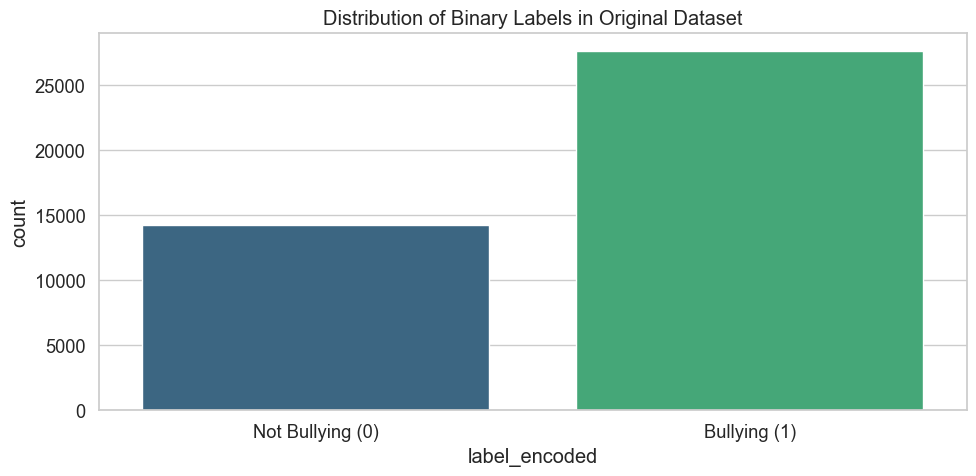

In [15]:
# Check the distribution of binary labels
plt.figure(figsize=(10, 5))
sns.countplot(x="label_encoded", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Binary Labels in Original Dataset")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.tight_layout()
plt.show()

## 3. Data Splitting


In [16]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 33525
Test set size: 8382


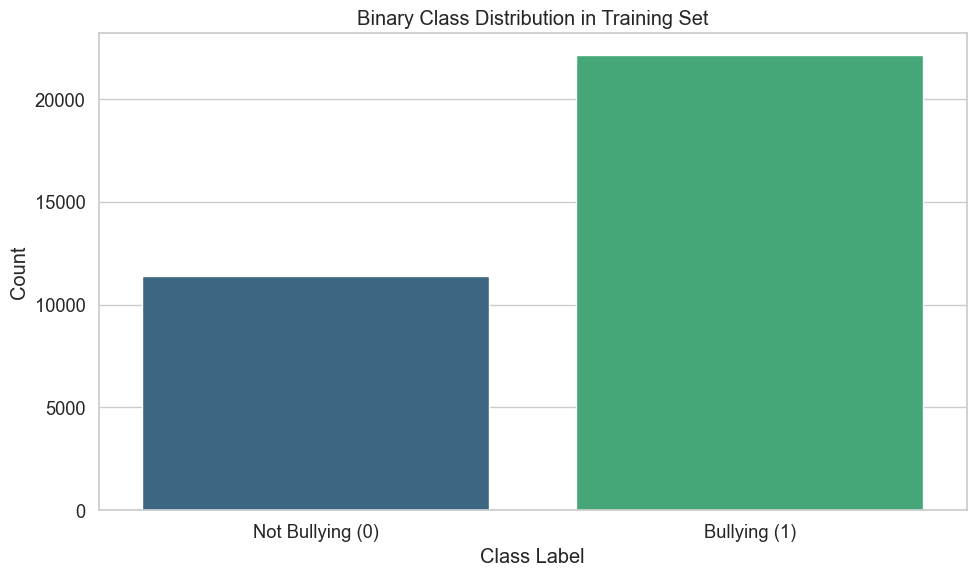

In [17]:
# Visualize the binary class distribution in training set
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, palette="viridis")
plt.title("Binary Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.xticks([0, 1], ["Not Bullying (0)", "Bullying (1)"])
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 4. Text Tokenization and Sequence Preparation for LSTM


In [18]:
# Initialize Keras tokenizer for sequence preparation
print("Initializing Keras tokenizer...")
max_words = 10000  # Maximum number of words to keep, based on word frequency
max_sequence_length = 100  # Maximum length of each sequence

# Initialize and fit tokenizer on training data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

Initializing Keras tokenizer...


In [19]:
# Convert texts to sequences and pad them to ensure uniform input size
def texts_to_sequences_and_pad(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(
        sequences, maxlen=max_sequence_length, padding="post", truncating="post"
    )
    return padded_sequences


# Get vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 65864


In [20]:
# Convert and pad training sequences
print("Converting training data to sequences...")
start_time = time.time()
X_train_sequences = texts_to_sequences_and_pad(X_train)
print(
    f"Training data sequence preparation completed in {time.time() - start_time:.2f} seconds"
)
print(f"Training sequence shape: {X_train_sequences.shape}")

Converting training data to sequences...
Training data sequence preparation completed in 0.53 seconds
Training sequence shape: (33525, 100)


In [21]:
# Convert and pad testing sequences
print("Converting testing data to sequences...")
start_time = time.time()
X_test_sequences = texts_to_sequences_and_pad(X_test)
print(
    f"Testing data sequence preparation completed in {time.time() - start_time:.2f} seconds"
)
print(f"Testing sequence shape: {X_test_sequences.shape}")

Converting testing data to sequences...
Testing data sequence preparation completed in 0.14 seconds
Testing sequence shape: (8382, 100)


## 5. Building and Training LSTM Model


In [22]:
# Configure and build LSTM model
print("Building LSTM model...")
embedding_dim = 128  # Embedding dimension

# Define the LSTM model architecture
model = Sequential()
model.add(
    Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length
    )
)
model.add(SpatialDropout1D(0.3))  # Apply dropout to prevent overfitting
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))  # Second LSTM layer
model.add(Dropout(0.3))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))  # Binary classification output

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath="../../models/lstm/best_binary_lstm_model.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)

# Train the LSTM model
print("Training LSTM model...")
batch_size = 32
epochs = 10

start_time = time.time()
history = model.fit(
    X_train_sequences,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training LSTM model...
Epoch 1/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7777 - loss: 0.4477
Epoch 1: val_loss improved from inf to 0.29634, saving model to ../../models/lstm/best_binary_lstm_model.h5


943/943 ━━━━━━━━━━━━━━━━━━━━ 104s 105ms/step - accuracy: 0.7778 - loss: 0.4476 - val_accuracy: 0.8562 - val_loss: 0.2963
Epoch 2/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9054 - loss: 0.2275
Epoch 2: val_loss did not improve from 0.29634
943/943 ━━━━━━━━━━━━━━━━━━━━ 94s 99ms/step - accuracy: 0.9054 - loss: 0.2275 - val_accuracy: 0.8589 - val_loss: 0.3176
Epoch 3/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9290 - loss: 0.1737
Epoch 3: val_loss did not improve from 0.29634
943/943 ━━━━━━━━━━━━━━━━━━━━ 95s 101ms/step - accuracy: 0.9290 - loss: 0.1738 - val_accuracy: 0.8625 - val_loss: 0.3104
Epoch 4/10
943/943 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9430 - loss: 0.1373
Epoch 4: val_loss did not improve from 0.29634
943/943 ━━━━━━━━━━━━━━━━━━━━ 90s 95ms/step - accuracy: 0.9430 - loss: 0.1373 - val_accuracy: 0.8607 - val_loss: 0.3429
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Model trained in 382.51 seconds


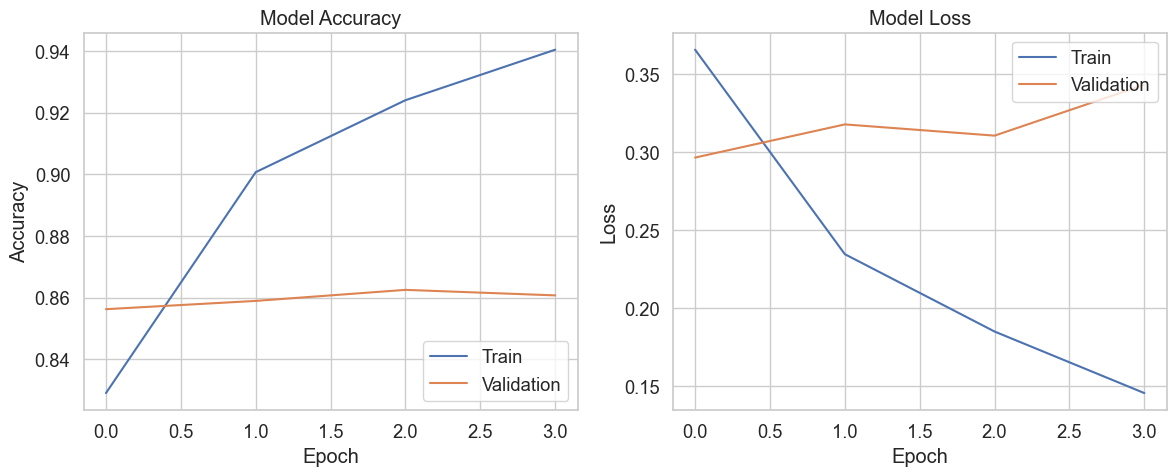

In [24]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="lower right")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")

plt.tight_layout()
plt.show()

## 6. Model Evaluation - Basic Metrics


In [25]:
# Make predictions and calculate basic metrics
print("Evaluating model...")
# Get predicted probabilities
y_pred_proba = model.predict(X_test_sequences)
# Convert to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate basic metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Accuracy: 0.8665
Precision: 0.8651
Recall: 0.8665
F1 Score: 0.8653


In [26]:
# Display classification report for binary classification
print("Classification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Not Bullying", "Bullying"],
        digits=5,
    )
)

Classification Report:
              precision    recall  f1-score   support

Not Bullying    0.82587   0.76999   0.79695      2852
    Bullying    0.88537   0.91627   0.90056      5530

    accuracy                        0.86650      8382
   macro avg    0.85562   0.84313   0.84876      8382
weighted avg    0.86513   0.86650   0.86531      8382



## 7. Confusion Matrix Visualization


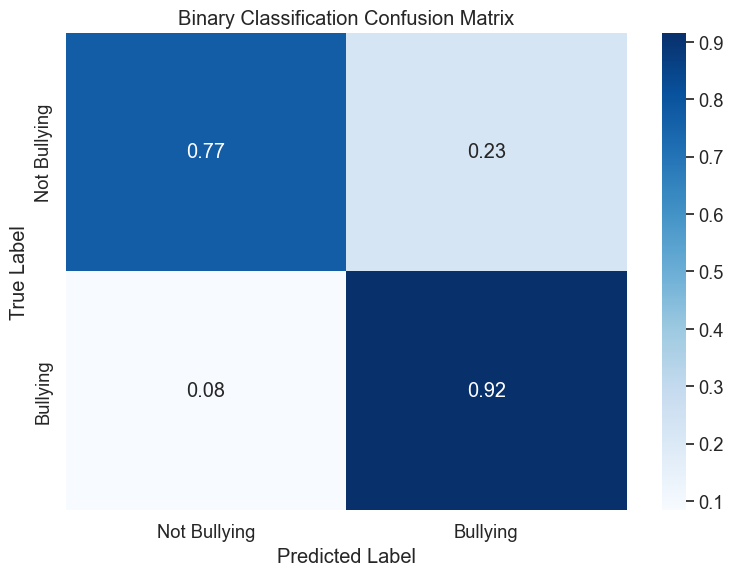

In [27]:
# Create and display confusion matrix for binary classification
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Not Bullying", "Bullying"],
    yticklabels=["Not Bullying", "Bullying"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary Classification Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Model Attention Analysis


262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


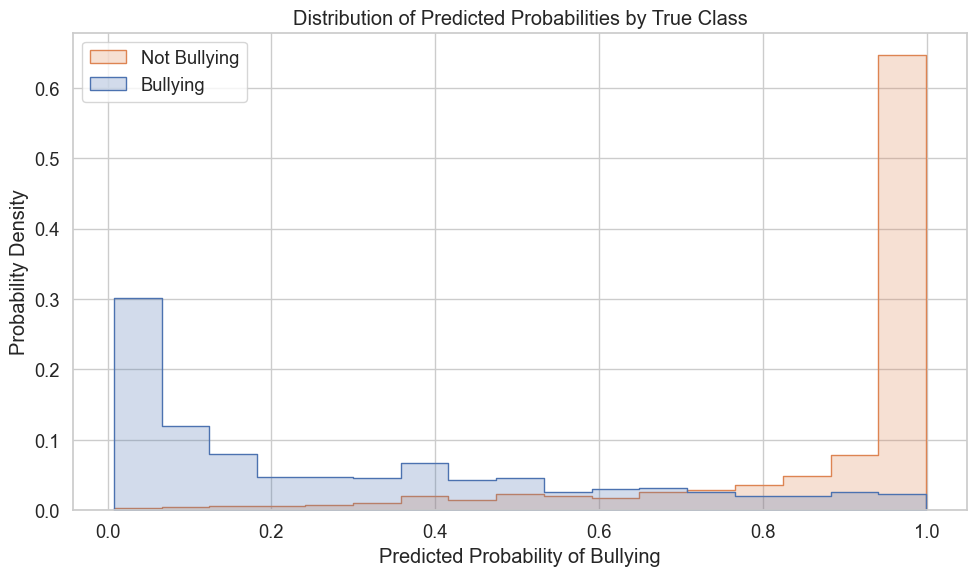

In [28]:
# For LSTM models, we don't have direct feature importance like in Random Forest
# Instead, let's analyze model performance on different classes

# Get prediction probabilities for each class
y_pred_probabilities = model.predict(X_test_sequences)

# Create a DataFrame with actual labels and predicted probabilities
prediction_df = pd.DataFrame(
    {"actual_label": y_test, "predicted_probability": y_pred_probabilities.flatten()}
)

# Visualize the distribution of predicted probabilities by actual class
plt.figure(figsize=(10, 6))
sns.histplot(
    data=prediction_df,
    x="predicted_probability",
    hue="actual_label",
    element="step",
    stat="probability",
    common_norm=False,
)
plt.title("Distribution of Predicted Probabilities by True Class")
plt.xlabel("Predicted Probability of Bullying")
plt.ylabel("Probability Density")
plt.legend(labels=["Not Bullying", "Bullying"])
plt.tight_layout()
plt.show()

## 9. ROC Curve Analysis


262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


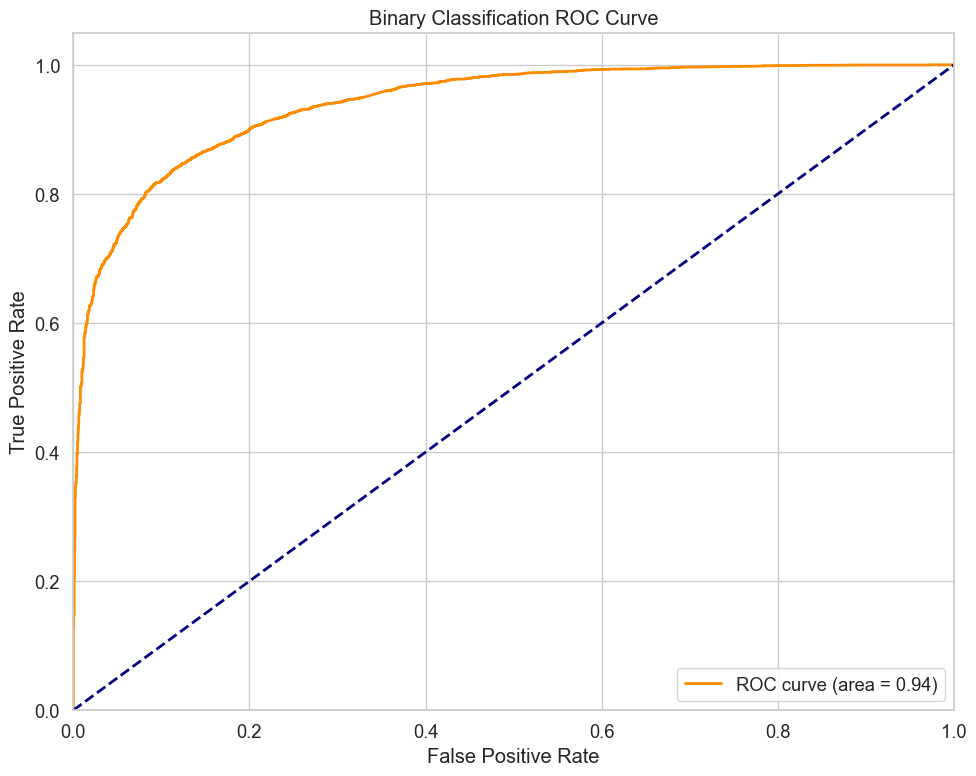

In [29]:
# ROC Curve and AUC for binary classification
y_score = model.predict(X_test_sequences).flatten()  # Probability of positive class

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary Classification ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis


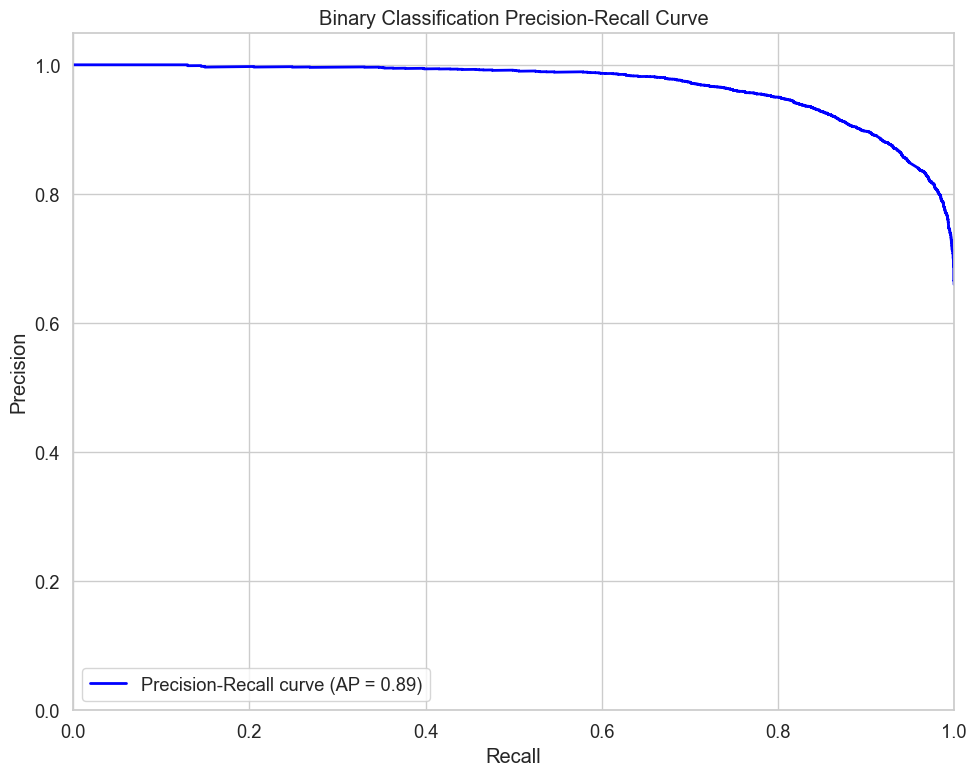

In [30]:
# Calculate Precision-Recall curve for binary classification
precision, recall, _ = precision_recall_curve(y_test, y_score)
avg_precision = precision_score(y_test, y_pred)

plt.figure(figsize=(10, 8))
plt.plot(
    recall,
    precision,
    color="blue",
    lw=2,
    label=f"Precision-Recall curve (AP = {avg_precision:.2f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Binary Classification Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 12. Model Summary and Saving


In [31]:
# Summary of the binary classification model
print("Binary Classification LSTM Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Maximum sequence length: {max_sequence_length}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
plt.show()

Binary Classification LSTM Model Summary:
Total samples in training set (with augmentation): 33525
Total samples in test set: 8382
Vocabulary size: 65864
Maximum sequence length: 100
Final model accuracy on test set: 0.8665


In [32]:
# Save the model
model.save("../../models/lstm/binary_no_augment_lstm_model.h5")
print("Model saved successfully")

# Save tokenizer for later use with the model
import pickle

with open("../../models/lstm/binary_tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved successfully")

Model saved successfully
Tokenizer saved successfully
